# M1 Applied Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

20th December 2023

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the M1 Applied Data Science module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [M1 Applied Data Science - Coursework Assignment](../DIS_MPhil_M1_Coursework.pdf).

In [14]:
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install tabulate  

In [15]:
# Import required libraries
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from scipy import stats
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
import numpy as np
from tabulate import tabulate
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
plt.style.use('sd2022.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'DejaVu Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11

## Question 3 - Dataset C: Missing Data and Outliers

In [16]:
# Load dataset C into a dataframe
file_path = '../data/C_MissingFeatures.csv' 
df_C = pd.read_csv(file_path,index_col=0)

(a) Summarise the missing data in this dataset. In your report, identify which features are affected.

In [17]:
# === Missing data summary =========================================================================

# Get features with missing values
features_with_missing = df_C.columns[df_C.isnull().any()].tolist()

# Create an empty dictionary to store rows affected by missing values for each feature
missing_rows_dict = {feature: [] for feature in features_with_missing}

# Iterate through features and find rows with missing values for each feature
for feature in features_with_missing:
    missing_rows_dict[feature] = df_C[df_C[feature].isnull()].index.tolist()

# Display missing features and the rows affected by missing values using tabulate
print("Features with missing values and the rows affected by missing values in each feature:\n")
print(tabulate(missing_rows_dict, headers='keys'))
print("Number of missing values: ", df_C.isnull().sum().sum())


Features with missing values and the rows affected by missing values in each feature:

Fea58      Fea142     Fea150     Fea233     Fea269     Fea299     Fea339     Fea355     Fea458     Fea466     Fea491
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------
Sample138  Sample138  Sample138  Sample138  Sample138  Sample138  Sample138  Sample138  Sample138  Sample138  Sample138
Sample143  Sample143  Sample143  Sample143  Sample143  Sample143  Sample143  Sample143  Sample143  Sample143  Sample143
Sample231  Sample231  Sample231  Sample231  Sample231  Sample231  Sample231  Sample231  Sample231  Sample231  Sample231
Sample263  Sample263  Sample263  Sample263  Sample263  Sample263  Sample263  Sample263  Sample263  Sample263  Sample263
Sample389  Sample389  Sample389  Sample389  Sample389  Sample389  Sample389  Sample389  Sample389  Sample389  Sample389
Number of missing values:  55


 (c) Perform the imputation using an appropriate model-based approach. In your report, justify the model you have chosen to use and compare the original and imputed distributions.

Optimal k value 46
Minimum MSE 0.001055210695366095


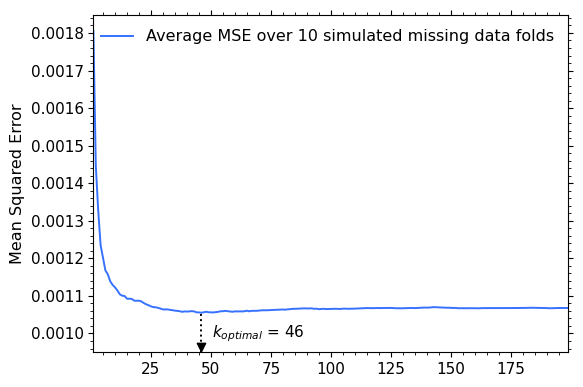

In [18]:
# === Hyperparameter tuning for KNNImputer =========================================================

# Remove rows with missing values and labels
X = df_C.drop(columns=['classification'])
X_non_missing = X.dropna()

# Define a range of k values to test for KNNImputer
k_list = range(1, 200, 1)

# Perform hyperparameter tuning for KNNImputer
def hyperparameter_tuning_imputer(X, features_with_missing, k_values, num_folds, seed):
    """Performs hyperparameter tuning for KNNImputer by calculating the average MSE for each k value
    across a number of folds with missing values. 

    Args:
        X (DataFrame): Dataframe containing the features with missing values
        features_with_missing (list): List of features with missing values
        k_values (list): List of k values to test
        num_folds (int): Number of folds to use
        seed (int): Random seed to use

    Returns:
        list: List of average MSE values for each k value
    """
    # Set up KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    # Initialise list to store average MSE values for each k value
    avg_mse_values = []
    # Loop over k values
    for k in k_values:
        # Initialise list to store MSE values for each fold
        fold_mse_values = []
        # Initialise KNNImputer
        imputer = KNNImputer(n_neighbors=k)
        # Loop over folds
        for _, missing_index in kf.split(X):
            # Create a copy of X 
            X_fold = X.copy()
            X_fold.reset_index(drop=True, inplace=True)
            # Set the to be imputed features to NaN in the fold
            for loc in features_with_missing:
                X_fold.loc[missing_index, loc] = np.nan
            # Impute the missing values
            X_fold_imputed = imputer.fit_transform(X_fold)
            # Calculate MSE for the fold
            train_mse = mean_squared_error(X, X_fold_imputed)
            fold_mse_values.append(train_mse)
        # Calculate average MSE for the k value
        avg_train_mse = np.mean(fold_mse_values)
        avg_mse_values.append(avg_train_mse)
    return avg_mse_values

mse_values = hyperparameter_tuning_imputer(X_non_missing, features_with_missing, k_list, num_folds=10, seed=seed_football_number)

# Find the optimal k value
min_mse_index = np.argmin(mse_values)
min_mse = mse_values[min_mse_index]
optimal_k = k_list[min_mse_index]
print("Optimal k value", optimal_k)
print("Minimum MSE", min_mse)

# Plotting MSE values for different k values on train and test sets
plt.figure()
plt.plot(k_list, mse_values, color = sd2022_blue, label='Average MSE over 10 simulated missing data folds')
plt.xlabel('')
plt.plot([optimal_k, optimal_k], [0.00095, min_mse], linestyle=':', color='black')
plt.scatter(optimal_k, 0.000965, marker='v', color='black')
plt.text(optimal_k*1.1, 0.00099, '$k_{optimal}$ = ' + str(optimal_k))
plt.ylabel('Mean Squared Error')
plt.legend()
plt.ylim(bottom=0.00095)
plt.show()

In [19]:
# === Imputation using KNNImputer ==================================================================

# Set up KNNImputer with optimal k value
k_optimal = 46
imputer = KNNImputer(n_neighbors=k_optimal)

# Impute missing values
X_imputed = imputer.fit_transform(X)

# Convert imputed data to dataframe
df_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

In [20]:
# === Imputation Results ===========================================================================

# Reduce the imputed dataset to only the imputed values
missing_rows = df_C[df_C[feature].isnull()].index.tolist()
df_imputed_only = df_imputed.loc[missing_rows, features_with_missing]

# Display the imputed values using tabulate
imputed_indeces = df_imputed_only.index.tolist()
imputed_features = df_imputed_only.columns.tolist()
imputed_values = df_imputed_only.values.tolist()

# Compute KS statistic and p-value for each feature with missing values
ks_p_values = []
for feature in features_with_missing:
    original_data = X[feature]  
    imputed_data = df_imputed[feature] 
    statistic, p_value = stats.ks_2samp(original_data, imputed_data)
    ks_p_values.append(p_value)
imputed_values_with_ks = imputed_values + [ks_p_values]

# Display the updated table including KS p-values 
print("Imputed values (KNN Imputer) with KS p-values:\n")
print(tabulate(imputed_values_with_ks, headers=imputed_features, showindex=imputed_indeces + ['KS p-values']))

Imputed values (KNN Imputer) with KS p-values:

                 Fea58    Fea142     Fea150    Fea233     Fea269    Fea299    Fea339    Fea355    Fea458    Fea466    Fea491
-----------  ---------  --------  ---------  --------  ---------  --------  --------  --------  --------  --------  --------
Sample138    0           4.21591  0.0389513  0.725018  0.165539          0   1.91339         0  0.912534  0.200398         0
Sample143    0           4.44719  0.0389513  0.857089  0.0500562         0   2.00811         0  0.93835   0.270082         0
Sample231    0.0150684   4.20384  0.0150684  0.793273  0.240881          0   2.03394         0  1.03282   0.237738         0
Sample263    0.0238829   4.20544  0          0.634363  0.168761          0   1.92054         0  1.1328    0.324455         0
Sample389    0.0150684   4.39703  0          0.490219  0.158721          0   2.09991         0  0.987642  0.22267          0
KS p-values  1           1        1          1         1                 1   

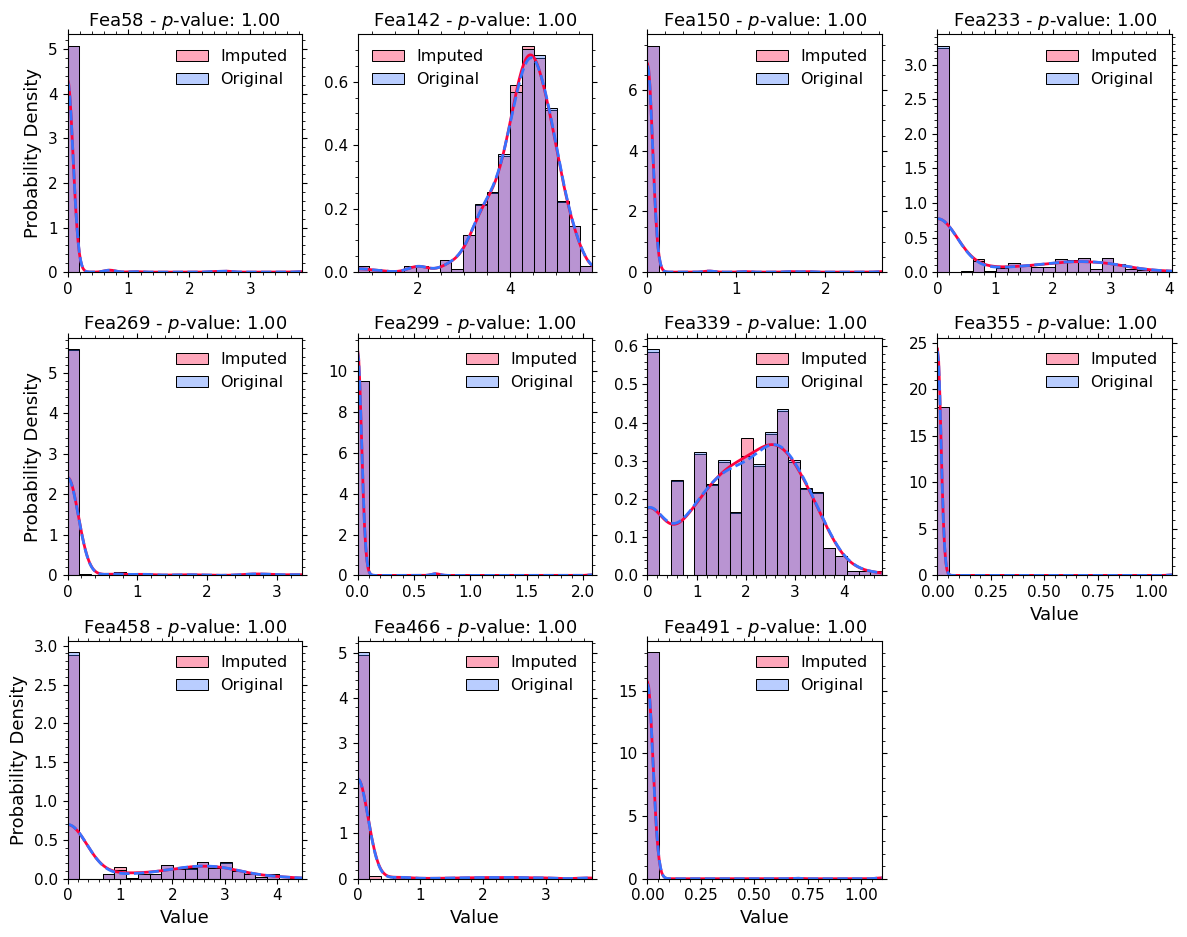

In [21]:
# === Compare distributions of original and imputed data ===========================================

plt.figure(figsize=(12, 9.5))
for i, feature in enumerate(features_with_missing):
    # Compute KS statistic and p-value for each feature with missing values
    original_data = X[feature]  
    imputed_data = df_imputed[feature] 
    statistic, p_value = stats.ks_2samp(original_data, imputed_data)
    # Plot histograms of original and imputed data
    plt.subplot(3, 4, i + 1)
    sns.histplot(df_imputed[feature], color=sd2022_red, alpha=0.35, stat="density", bins=20, label='Imputed', kde=True, line_kws={'linewidth': 2})
    sns.histplot(X[feature], color=sd2022_blue, alpha=0.35, stat="density", bins=20, label='Original', kde=True, line_kws={'linewidth':2, 'linestyle': 'dashed'})
    plt.title(f'{feature} - $p$-value: {p_value:.2f}', size=13)
    plt.xlabel('Value', size=13)
    plt.ylabel('Probability Density', size=13)
    plt.legend()
    # Remove y-axis label for all but the first column
    if i % 4 != 0:
        plt.ylabel('')
    # Remove x-axis label for all but the bottom row
    if i < 7:
        plt.xlabel('')

plt.tight_layout()
plt.show()

In [22]:
# === Comparison with IterativeImputer =============================================================

# # COMMENT OUT THIS SECTION IF YOU DO NOT WANT TO RUN THE COMPARISON WITH ITERATIVE IMPUTER

# # Impute missing values using IterativeImputer
# imputer_iterative = IterativeImputer(random_state=seed_dob, min_value=0)

# # Impute missing values
# X_imputed_iterative = imputer_iterative.fit_transform(X)

# # Convert imputed data to dataframe
# df_imputed_it = pd.DataFrame(X_imputed_iterative, columns=X.columns, index=X.index)

# # Reduce the imputed dataset to only the imputed values
# missing_rows_it = df_C[df_C[feature].isnull()].index.tolist()
# df_imputed_only_it = df_imputed_it.loc[missing_rows, features_with_missing]

# # Display the imputed values using tabulate
# imputed_indeces_it = df_imputed_only_it.index.tolist()
# imputed_features_it = df_imputed_only_it.columns.tolist()
# imputed_values_it = df_imputed_only_it.values.tolist()
# print("Imputed values (Iterative Imputer):\n")
# print(tabulate(imputed_values_it, headers=imputed_features, showindex=imputed_indeces))


(d) Implement a standardisation approach to detect outliers. In your report, explain how the standardisation approach works and identify the outliers you have found.

In [23]:
# === Outlier Detection ============================================================================

# Detect outliers in the original data using a custom IQR method (Tukey's fences)
def detect_outliers_iqr(df,  threshold=3):
    """Detect outliers using the IQR method (Tukey's fences).

    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (int, optional): Threshold for outlier detection. Defaults to 3.

    Returns:
        total_outliers (int): Total number of outlier values.
        num_rows_affected (int): Number of rows affected by outliers.
        num_features_affected (int): Number of features affected by outliers.
        outliers (pd.DataFrame): Boolean dataframe indicating outliers.
    """
    # Initialise RobustScaler
    scaler = RobustScaler()
    # Scale the data using RobustScaler
    X_robust = scaler.fit_transform(df)
    df_robust = pd.DataFrame(X_robust, columns=df.columns, index=df.index)
    # Calculate the custom IQR 
    Q1 = df_robust.quantile(0.25)
    Q3 = df_robust.quantile(0.75)
    IQR = Q3 - Q1
    # Detect outliers using the IQR method
    outliers = ((df_robust < (Q1 - threshold * IQR)) | (df_robust > (Q3 +  threshold * IQR)))
    # Calculate the number of total outlier values
    total_outliers = outliers.sum().sum()
    # Calculate the number of rows affected by outliers
    affected_rows = df_robust[outliers.any(axis=1)].index.tolist()
    num_rows_affected = len(affected_rows)
    # Calculate the number of features affected by outliers
    affected_features = df_robust.columns[outliers.any(axis=0)].tolist()
    num_features_affected = len(affected_features)
    return total_outliers, num_rows_affected, num_features_affected, outliers

total_outliers_iqr, num_rows_affected_iqr, num_features_affected_iqr, _ = detect_outliers_iqr(df_imputed, threshold=3)

# Display outlier detection results 
print(f"Total number of outliers: {total_outliers_iqr}")
print(f"Number of observations affected by outliers: {num_rows_affected_iqr}")
print(f"Number of features affected by outliers: {num_features_affected_iqr}")

Total number of outliers: 6042
Number of observations affected by outliers: 408
Number of features affected by outliers: 365


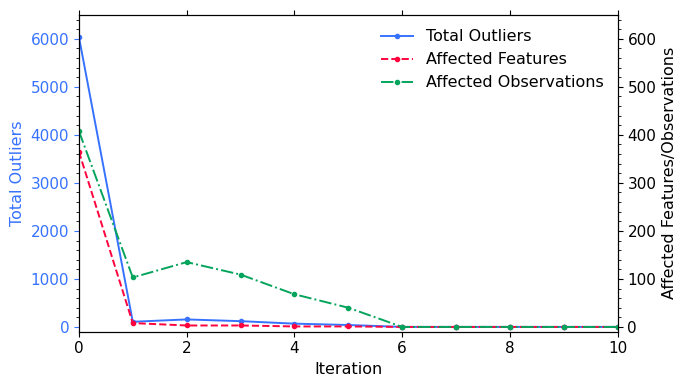

Outlier Correction converged after 7 iterations
Total number of outliers after correction: 0
Number of rows affected by outliers after correction: 0
Number of features affected by outliers after correction: 0


In [24]:
# === Outlier Correction ===========================================================================

# Correct outliers with KNNImputer 
def iterative_outlier_correction_knn(df, threshold=3, k=46, num_iterations=10):
    """Corrects outliers iteratively using KNNImputer.

    The function detects outliers using the IQR method and replaces them with NaN values.
    The NaN values are then imputed using KNNImputer. The process is repeated for a number of iterations
    until the number of outliers is zero. Note that there is a restriction that only the original outliers
    are allowed to be imputed in each iteration.

    Args:
        df (DataFrame): Dataframe containing the outliers
        threshold (int, optional): Threshold for outlier detection. Defaults to 3.
        k (int, optional): Number of neighbours to use for KNNImputer. Defaults to 46.
        num_iterations (int, optional): Number of iterations to perform. Defaults to 10.

    Returns:
        DataFrame: Dataframe with corrected outliers
        list: List of total number of outliers for each iteration
        list: List of number of rows affected by outliers for each iteration
        list: List of number of features affected by outliers for each iteration
    """
    # Copy original dataframe
    df_copy = df.copy()
    # Initialise outlier statistics lists
    total_outliers_list = []
    num_rows_affected_list = []
    num_features_affected_list = []
    # Loop over number of iterations
    for i in range(num_iterations):
        # Detect outliers
        total_outliers, num_rows_affected, num_features_affected, outliers = detect_outliers_iqr(df, threshold)
        # Store outlier statistics
        total_outliers_list.append(total_outliers)
        num_rows_affected_list.append(num_rows_affected)
        num_features_affected_list.append(num_features_affected)
        # Replace outliers with NaN only in the original data
        df_copy[outliers] = np.nan
        # Impute NaN values using KNNImputer and create an updated dataframe
        imputer = KNNImputer(n_neighbors=k)
        df_updated = pd.DataFrame(imputer.fit_transform(df_copy), columns=df_copy.columns, index=df_copy.index)
        # Update the original dataframe with the imputed values only for the original outliers
        df[outliers] = np.where(outliers, df_updated, df)
    return df, total_outliers_list, num_rows_affected_list, num_features_affected_list

# Impute outlier values iteratively
df_outliers = df_imputed.copy()
df_corrected, total_outliers_list, num_rows_affected_list, num_features_affected_list = iterative_outlier_correction_knn(df_outliers, k=46, num_iterations=11, threshold=3)

# Plot the number of outliers, affected rows and affected features for each iteration
fig, ax1 = plt.subplots(figsize=(7, 4))

ax1.plot(total_outliers_list, marker='.', linestyle='-', color=sd2022_blue, label='Total Outliers')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total Outliers', color=sd2022_blue)
ax1.tick_params('y', colors=sd2022_blue)
ax1.set_ylim(bottom = -100, top = 6500)

ax2 = ax1.twinx()
ax2.plot(num_features_affected_list, marker='.', linestyle='--', color=sd2022_red, label='Affected Features')
ax2.plot(num_rows_affected_list, marker='.', linestyle='-.', color=sd2022_green, label='Affected Observations')
ax2.set_ylabel('Affected Features/Observations')
ax2.tick_params('y')
ax2.set_ylim(bottom = -10, top = 650)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2 
labels = labels1 + labels2 
ax1.legend(lines, labels, loc='upper right')
ax = plt.gca()
ax.xaxis.set_minor_locator(plt.NullLocator())
plt.show()

# Display imputation convergence
iterations_converged = total_outliers_list.index(0) + 1
print(f"Outlier Correction converged after {iterations_converged} iterations")

# Check final corrected data for outliers
total_outliers_final, num_rows_affected_final, num_features_affected_final, _ = detect_outliers_iqr(df_corrected, threshold=3)

# Display final outlier statistics
print(f"Total number of outliers after correction: {total_outliers_final}")
print(f"Number of rows affected by outliers after correction: {num_rows_affected_final}")
print(f"Number of features affected by outliers after correction: {num_features_affected_final}")


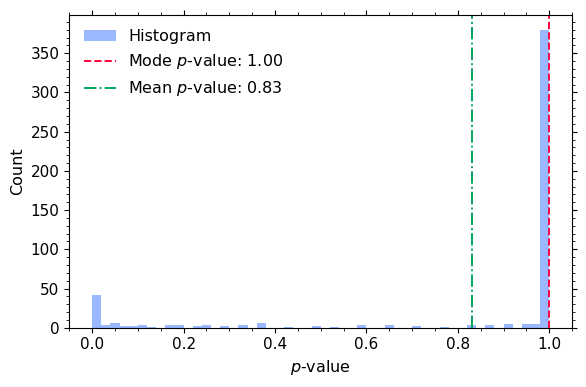

Number of features with p-values below 0.01: 38


In [25]:
# === Compare distributions of original and final data =============================================

# Compute KS statistic and p-value for each feature
statistic_list = []
p_value_list = []
for feature in X.columns:
    original_data = X[feature]  
    corrected_data = df_corrected[feature] 
    statistic, p_value = stats.ks_2samp(original_data, corrected_data)
    statistic_list.append(statistic)
    p_value_list.append(p_value)

# Calculate the mean and mode of the p-values
p_mean= np.mean(p_value_list)
p_mode = stats.mode(p_value_list).mode

# Plot histogram of p-values
plt.figure()
plt.hist(p_value_list, bins=50, color=sd2022_blue, alpha=0.5, label='Histogram')
plt.axvline(x=p_mode, color=sd2022_red, linestyle='--', label=f'Mode $p$-value: {p_mode:.2f}')
plt.axvline(x=p_mean, color=sd2022_green, linestyle='-.', label=f'Mean $p$-value: {p_mean:.2f}')

plt.xlabel('$p$-value')
plt.ylabel('Count')
plt.legend()
plt.xlim(-0.05, 1.05)
plt.show()

# Get number of features with p-values below 0.01
num_features_low_p = np.sum(np.array(p_value_list) < 0.01)
print("Number of features with p-values below 0.01:", num_features_low_p)


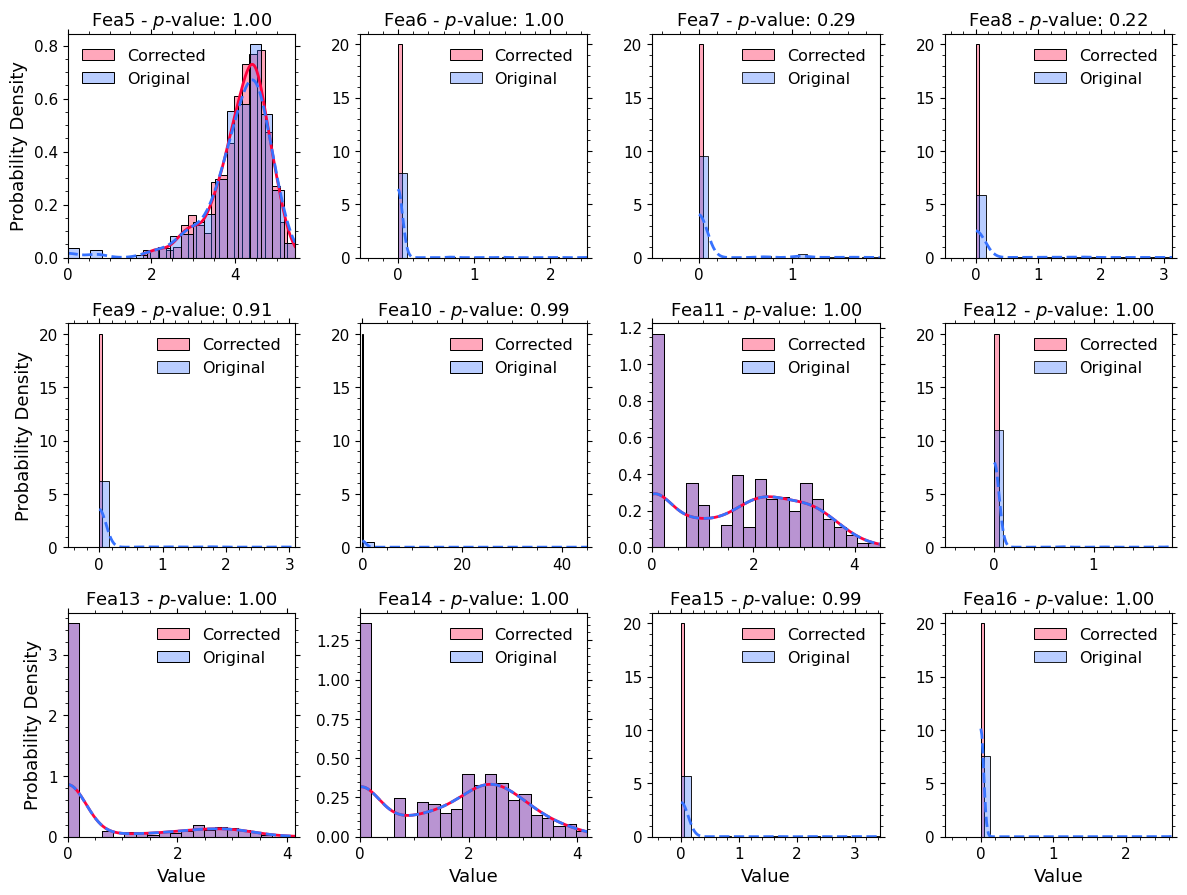

In [26]:
# === Compare distributions of original and imputed data ===========================================

# Get 12 features
features_12 = X.columns[4:16]

# Plot distributions of original and outlier corrected data for first 12 features
plt.figure(figsize=(12, 11.5))  
for i, feature in enumerate(features_12):
    # Compute KS statistic and p-value for each feature
    original_data_12 = X[feature]  
    corrected_data_12 = df_corrected[feature] 
    statistic, p_value = stats.ks_2samp(original_data_12, corrected_data_12)
    # Plot histograms
    plt.subplot(4, 4, i + 1)  
    sns.histplot(df_corrected[feature], color=sd2022_red, alpha=0.35, stat="density", bins=20, label='Corrected', kde=True, line_kws={'linewidth': 2})
    sns.histplot(X[feature], color=sd2022_blue, alpha=0.35, stat="density", bins=20, label='Original', kde=True, line_kws={'linewidth': 2, 'linestyle': 'dashed'})
    plt.title(f'{feature} - $p$-value: {p_value:.2f}', size=13)
    plt.xlabel('Value', size=13)
    plt.ylabel('Probability Density', size=13)
    plt.legend()
    # Remove y-axis label for all but the first column
    if i % 4 != 0:
        plt.ylabel('')
    # Remove x-axis label for all but the bottom row
    if i < 8: 
        plt.xlabel('')
plt.tight_layout()
plt.show()